In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

from datetime import datetime as dt
import itertools
from tqdm import tqdm
from scipy.stats import norm, t
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
# from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler,MinMaxScaler
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score,log_loss
# import lightgbm as lgb
import gc

from sklearn.model_selection import StratifiedKFold,KFold
from sklearn import metrics
import xgboost as xgb


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
# ss

In [11]:
train_ori = pd.read_csv('train.csv',parse_dates=['date'])
test_ori = pd.read_csv('test.csv',parse_dates=['date'])
ss =pd.read_csv('SampleSubmission.csv')

In [5]:
# train.site_latitude.sort_values().unique()


In [6]:
# a = train.site_latitude.unique()
def get_prev(df,shifts = 1,col = 'pm2_5'):
    df['shifted_'+str(shifts)] = df.shift(shifts)[col].values
    return df
def target_encode(df_train,df_test,target,groupss):
    groupss_target_mean = df_train.groupby(groupss)[target].mean()
    groupss_target_max = df_train.groupby(groupss)[target].max()
    groupss_target_min = df_train.groupby(groupss)[target].min()
    groupss_target_std = df_train.groupby(groupss)[target].std()
    groupss_target_median = df_train.groupby(groupss)[target].apply(lambda x : np.median(x))
    groupss_target_q95 = df_train.groupby(groupss)[target].apply(lambda x : np.quantile(x,0.95))
    groupss_target_q05 = df_train.groupby(groupss)[target].apply(lambda x : np.quantile(x,0.05))
    groupss_target_skew = df_train.groupby(groupss)[target].skew()
    groupss_target_kurt = df_train.groupby(groupss)[target].apply(lambda x : x.kurtosis())
    # groupss_target_mean = df_train.groupby(groupss)[target].mean()
    df_test[groupss+target+'enc'] = df_test[groupss].map(groupss_target_mean)
    df_test[groupss+target+'enc'].fillna((df_test[groupss+target+'enc'].mean()), inplace=True)
    df_test[groupss+target+'enc1'] = df_test[groupss].map(groupss_target_max)
    df_test[groupss+target+'enc1'].fillna((df_test[groupss+target+'enc1'].mean()), inplace=True)
    df_test[groupss+target+'enc2'] = df_test[groupss].map(groupss_target_min)
    df_test[groupss+target+'enc2'].fillna((df_test[groupss+target+'enc2'].mean()), inplace=True)
    df_test[groupss+target+'enc3'] = df_test[groupss].map(groupss_target_std)
    df_test[groupss+target+'enc3'].fillna((df_test[groupss+target+'enc3'].mean()), inplace=True)
    df_test[groupss+target+'enc4'] = df_test[groupss].map(groupss_target_median)
    df_test[groupss+target+'enc4'].fillna((df_test[groupss+target+'enc4'].mean()), inplace=True)
    df_test[groupss+target+'enc5'] = df_test[groupss].map(groupss_target_q95)
    df_test[groupss+target+'enc5'].fillna((df_test[groupss+target+'enc5'].mean()), inplace=True)
    df_test[groupss+target+'enc6'] = df_test[groupss].map(groupss_target_q05)
    df_test[groupss+target+'enc6'].fillna((df_test[groupss+target+'enc6'].mean()), inplace=True)
    df_test[groupss+target+'enc7'] = df_test[groupss].map(groupss_target_skew)
    df_test[groupss+target+'enc7'].fillna((df_test[groupss+target+'enc7'].mean()), inplace=True)
    df_test[groupss+target+'enc8'] = df_test[groupss].map(groupss_target_kurt)
    df_test[groupss+target+'enc8'].fillna((df_test[groupss+target+'enc8'].mean()), inplace=True)
    tmp =np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : x.skew())
        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc7'] = tmp
    tmp =np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : x.kurtosis())

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc8'] = tmp
    
    tmp =np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : np.quantile(x,0.05))

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc6'] = tmp
    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1991032)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : np.quantile(x,0.95))

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc5'] = tmp



    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1991035)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].apply(lambda x : np.median(x))

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc4'] = tmp



    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_mean = df_train.iloc[idx_1].groupby(groupss)[target].mean()

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_mean)
    df_train[groupss+target+'enc'] = tmp



    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1991025)
    for idx_1, idx_2 in kf.split(df_train):
        target_max = df_train.iloc[idx_1].groupby(groupss)[target].max()

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_max)
    df_train[groupss+target+'enc1'] = tmp
    # from sklearn.model_selection import KFold/
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 1990325)
    for idx_1, idx_2 in kf.split(df_train):
        target_min = df_train.iloc[idx_1].groupby(groupss)[target].min()

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_min)
    df_train[groupss+target+'enc2'] = tmp
    # from sklearn.model_selection import KFold
    tmp = np.repeat(np.nan, df_train.shape[0])
    kf = KFold(n_splits = 5, shuffle=True,random_state = 19910325)
    for idx_1, idx_2 in kf.split(df_train):
        target_std = df_train.iloc[idx_1].groupby(groupss)[target].std()

        tmp[idx_2] = df_train[groupss].iloc[idx_2].map(target_std)
    df_train[groupss+target+'enc3'] = tmp
    df_train[groupss+target+'enc'].fillna((df_train[groupss+target+'enc'].mean()), inplace=True)
    df_train[groupss+target+'enc1'].fillna((df_train[groupss+target+'enc1'].mean()), inplace=True)
    df_train[groupss+target+'enc2'].fillna((df_train[groupss+target+'enc2'].mean()), inplace=True)
    df_train[groupss+target+'enc3'].fillna((df_train[groupss+target+'enc3'].mean()), inplace=True)
    df_train[groupss+target+'enc4'].fillna((df_train[groupss+target+'enc4'].mean()), inplace=True)
    df_train[groupss+target+'enc5'].fillna((df_train[groupss+target+'enc5'].mean()), inplace=True)
    df_train[groupss+target+'enc6'].fillna((df_train[groupss+target+'enc6'].mean()), inplace=True)
    return df_train, df_test


In [222]:
# train.resample('d')['pm2_5'].mean()
train

date
2019-03-14    31.415000
2019-03-15    28.940000
2019-03-16    34.349272
2019-03-17    43.131879
2019-03-18    30.584458
                ...    
2020-08-16    88.384117
2020-08-17    95.950134
2020-08-18    68.006909
2020-08-19    51.505567
2020-08-20    58.179890
Freq: D, Name: pm2_5, Length: 526, dtype: float64

In [535]:
from sklearn.preprocessing import RobustScaler

In [584]:
def preprocess(train,test):
    le = LabelEncoder()
    train['Train']=1
    test['Train']=0
#     home_teams=train['Home Team'].unique()
    all_data=pd.concat([train,test])
    all_data['month'] = all_data.date.dt.month
    all_data['year'] = all_data.date.dt.year
    all_data['day'] = all_data.date.dt.day
    all_data['week'] = all_data.date.dt.week
    all_data['dow'] = all_data.date.dt.dayofweek
    all_data['woy'] = all_data.date.dt.weekofyear
    all_data[['site_latitude','site_longitude']] =  all_data[['site_latitude','site_longitude']] .round(5)
#     for c in all_data.drop(['date','pm2_5'], axis = 1).select_dtypes(exclude = 'object').columns:
#         all_data[c] = all_data[c].fillna(all_data[c].min()-(all_data[c].max()-all_data[c].min()))
    all_data['device'] = le.fit_transform(all_data['device'].values.reshape(-1,1))
    le =LabelEncoder()
    all_data['site_code'] = le.fit_transform(all_data['site_latitude'].values.reshape(-1,1))
    all_data = get_prev(all_data.reset_index(drop = True),shifts = 1,col = 'pm2_5')
    train = all_data.loc[all_data.Train == 1].reset_index(drop = True)
    test = all_data.loc[all_data.Train == 0].reset_index(drop = True)
#     scale= all_data.drop('pm2_5',axis = 1).select_dtypes(include = 'float').columns
#     rs = RobustScaler()
#     train[scale] = rs.fit_transform(train[scale])
#     test[scale] = rs.transform(test[scale])
    train,test = target_encode(train,test,target = 'pm2_5',groupss = 'site_latitude')
    return train, test
def _get_X_Y_DF_from_CV(train_X, train_Y, train_index, validation_index):
        X_train, X_validation = (
            train_X.iloc[train_index],
            train_X.iloc[validation_index],
        )
        y_train, y_validation = (
            train_Y.iloc[train_index],
            train_Y.iloc[validation_index],
        )
        return X_train, X_validation, y_train, y_validation
    

def train_lgb(X,y,test_data,params,seed_lgb,shuffle_lgb,kf):
    features_importance= pd.DataFrame({'Feature':[], 'Importance':[]})
    models =[]
    train_X = X.copy()
    train_Y = y.copy()
    test_X = test_data.copy()
    print(f"Shape of train_X : {train_X.shape}, test_X: {test_X.shape}, train_Y: {train_Y.shape}")

    predictors = list(train_X.columns)
    # print(f"List of features to be used {list(predictors)}")

    # Selecting n_splits to be 3, since class 42 has 
    # just 3 instances
    kf = GroupKFold(n_splits=K_FOLDS)
    y_oof_lgb = np.zeros(shape=(len(train_X),))
    y_predicted_lgb = np.zeros(shape=(len(test_X),))
    cv_scores = []
    fold = 0
    n_folds = K_FOLDS
    for train_index, validation_index in kf.split(train_X,train_Y,groups = train_X['site_code']):
        fold += 1
        print(f"fold {fold} of {n_folds}")

        X_train, X_validation, y_train, y_validation = _get_X_Y_DF_from_CV(
            train_X, train_Y, train_index, validation_index
        )

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_validation, y_validation, reference=lgb_train)

        model = lgb.train(
            lgb_params,
            lgb_train,
            valid_sets=[lgb_train, lgb_eval],
            verbose_eval=100,
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            num_boost_round=N_ESTIMATORS,
            feature_name=predictors,
            categorical_feature="auto",
        )
        del lgb_train, lgb_eval, train_index, X_train, y_train
        gc.collect()

        y_oof_lgb[validation_index] = model.predict(
            X_validation, num_iteration=model.best_iteration
        )

        y_predicted_lgb += model.predict(
            test_data.values, num_iteration=model.best_iteration
        )
        fold_importance_df= pd.DataFrame({'Feature':[], 'Importance':[]})
        fold_importance_df['Feature']= predictors
        fold_importance_df['Importance']= model.feature_importance()
        fold_importance_df["fold"] = fold + 1
        features_importance = pd.concat([features_importance, fold_importance_df], axis=0)
        models.append(model)

        best_iteration = model.best_iteration
        print(f"Best number of iterations for fold {fold} is: {best_iteration}")

        cv_oof_score = metrics.mean_absolute_error(y_validation, y_oof_lgb[validation_index])
        cv_scores.append(cv_oof_score)
        print(f"CV OOF Score for fold {fold} is {cv_oof_score}")

        del validation_index, X_validation, y_validation
        gc.collect()

    y_predicted_lgb /= n_folds
    oof_score = round(metrics.mean_absolute_error(train_Y, y_oof_lgb), 5)
    avg_cv_scores = round(sum(cv_scores) / len(cv_scores), 5)
    std_cv_scores = round(np.array(cv_scores).std(), 5)
    return y_predicted_lgb,models,y_oof_lgb,oof_score,features_importance
def train_catbo(train_X, train_Y,test_X,params,seed_cat,shuffle_cat):
# model.fit(train_pool,plot=True,eval_set=test_pool)
    kf = KFold(random_state=seed_cat,n_splits=K_FOLDS, shuffle=shuffle_cat)
    y_oof = np.zeros(shape=(len(train_X),))
    y_predicted = np.zeros(shape=(len(test_X),))
    cv_scores = []
    models = []
    fold = 0
    n_folds = kf.get_n_splits()
    for train_index, validation_index in kf.split(X=train_X, y=train_Y):
        fold += 1
        print(f"fold {fold} of {n_folds}")

        X_train, X_validation, y_train, y_validation = _get_X_Y_DF_from_CV(
            train_X, train_Y, train_index, validation_index
        )

        train_pool = Pool(data=X_train, label=y_train)
        eval_pool = Pool(data=X_validation, label=y_validation.values) 
        model = CatBoostRegressor(**params)
        model.fit(train_pool,plot=True,eval_set=eval_pool)
        del train_index, X_train, y_train
        gc.collect()
        models.append(model)
        y_oof[validation_index] = model.predict(
            X_validation )

        y_predicted += model.predict(
            test_X.values
        )

    #     best_iteration = model.best_iteration
    #     print(f"Best number of iterations for fold {fold} is: {best_iteration}")

        cv_oof_score = metrics.mean_absolute_error(y_validation, y_oof[validation_index])
        cv_scores.append(cv_oof_score)
        print(f"CV OOF Score for fold {fold} is {cv_oof_score}")

        del validation_index, X_validation, y_validation
        gc.collect()

    y_predicted /= n_folds
    oof_score = round(metrics.mean_absolute_error(train_Y, y_oof), 5)
    avg_cv_scores = round(sum(cv_scores) / len(cv_scores), 5)
    std_cv_scores = round(np.array(cv_scores).std(), 5)
    return y_predicted,models,y_oof,oof_score
def train_xgb(X,y,test_data,params,num_iter=1500,es = 100,ve = 100,seed_xgb=42,shuffle_xgb=True):
    features = X.columns
    X = X.values
    # y = train['target'].values
    y_oof = np.zeros(shape=(len(X),))
    y_predicted = np.zeros(shape=(len(test_data), ))
    cv_scores = []
    models = []
    kf = KFold(random_state=seed_xgb,n_splits=K_FOLDS, shuffle=shuffle_xgb)

    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        print(' xgb kfold: {}  of  {} : '.format(i+1, K_FOLDS ))
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        d_train = xgb.DMatrix(X_train, y_train) 
        d_valid = xgb.DMatrix(X_valid, y_valid) 
        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        xgb_model = xgb.train(params, d_train, num_iter, watchlist,
                              early_stopping_rounds=es, 
                            verbose_eval=ve)
        models.append(xgb_model)
        y_oof[test_index] = xgb_model.predict(xgb.DMatrix(X_valid), 
                            ntree_limit=xgb_model.best_ntree_limit)
        y_predicted += xgb_model.predict(xgb.DMatrix(test_data[features].values), 
                            ntree_limit=xgb_model.best_ntree_limit) 
        
        cv_oof_score = metrics.mean_absolute_error(y_valid, y_oof[test_index])
        cv_scores.append(cv_oof_score)
        print(f"CV OOF Score for fold {i+1} is {cv_oof_score}")

#         del validation_index, X_validation, y_validation
#         gc.collect()

    y_predicted /= K_FOLDS
    oof_score = round(metrics.mean_absolute_error(y, y_oof), 5)
    avg_cv_scores = round(sum(cv_scores) / len(cv_scores), 5)
    std_cv_scores = round(np.array(cv_scores).std(), 5)
    return y_predicted,models,y_oof,oof_score 
def train_keras(X,train,test_data):
#     train ['Original_score'] = le.inverse_transform(train.Score)
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     X_scaled = scaler.fit_transform(X)
#     X_scaled = pd.DataFrame(X_scaled)
#     Y = pd.get_dummies(train['Original_score'])
    X_scaled = X.values
    Y = Y.values
    inp = len(X.columns)
    y_oof = np.zeros(shape=(len(X), NUM_CLASSES))
    y_predicted = np.zeros(shape=(len(test_data), NUM_CLASSES))
    cv_scores = []
    models = []
    kf = KFold(random_state=SEED,n_splits=K_FOLDS, shuffle=True)
    for i, (train_index, test_index) in enumerate(kf.split(X_scaled, Y)):
        print(' keras kfold: {}  of  {} : '.format(i+1, K_FOLDS ))
        X_train, X_valid = X_scaled[train_index], X_scaled[test_index]
        y_train, y_valid = Y[train_index], Y[test_index]
#         np.random.seed(SEED)
        my_model = baseline_model(inp)
        my_model.fit(X_train, y_train,
                     validation_data=(X_valid, y_valid),
                     epochs=1000,
                     callbacks=[EarlyStopping(patience=20)],
                     verbose=0)
        
        models.append(my_model)
        y_oof[test_index] = my_model.predict(X_valid)
        y_predicted += my_model.predict(test_data.values) 
        del my_model
        gc.collect()
        cv_oof_score = metrics.log_loss(y_valid, y_oof[test_index])
        cv_scores.append(cv_oof_score)
        print(f"CV OOF Score for fold {i+1} is {cv_oof_score}")

#         del validation_index, X_validation, y_validation
#         gc.collect()

    y_predicted /= K_FOLDS
    oof_score = round(metrics.log_loss(y, y_oof), 5)
    avg_cv_scores = round(sum(cv_scores) / len(cv_scores), 5)
    std_cv_scores = round(np.array(cv_scores).std(), 5)
    return y_predicted,models,y_oof,oof_score 
from matplotlib import pyplot as plt
# Keras imports
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from keras.callbacks import EarlyStopping
import os 
import random
import numpy as np 

DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# tensorflow random seed 
import tensorflow as tf 
def seedTF(seed=DEFAULT_RANDOM_SEED):
    tf.random.set_seed(seed)
    
# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTF(seed)
    seedTorch(seed)
seedEverything(42)
seed = 42

def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:10].index
    best_features = feature_importance_df_[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by="Importance", ascending=False)[:50]
    best_features.reset_index(inplace=True)
    print(best_features.dtypes)
    plt.figure(figsize=(8, 10))
    sns.barplot(x="Importance", y="Feature", data=best_features)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
def preds_to_sub(test,preds,name = None,log = False):
    if log :
        test['pm2_5'] = np.exp(preds)
    else:
        test['pm2_5'] = preds
    sub = test[['ID','pm2_5']]
    if name:
        sub.to_csv(name+'.csv', index = False)
    return sub

# def preds_to_sub(test,le,y_predicted,save = False):
#     Test = test.copy()
#     cols=le.inverse_transform([*range(3)])
#     Test[cols]= y_predicted
#     submit = Test[["Game_ID",'Away win', 'Draw', 'Home Win']]
#     submit.drop_duplicates(subset = ["Game_ID"], inplace=True)
#     submit = submit.reset_index(drop=True)
#     if save:
#         submit.to_csv("submission_gbm15.csv", index=False)
#     return submit   

In [609]:
# sns.distplot(train['pm2_5'])
# train.loc[train.pm2_5 == train.pm2_5.max() ]
# plt.plot(train.loc[(train.site_latitude == 0.2182)& (train.site_longitude == 32.6176),'date'],
# train.loc[(train.site_latitude == 0.2182)& (train.site_longitude == 32.6176),'pm2_5'])
# test.date.min()
# test.device.isin(train.device.unique()).all()
train,test = preprocess(train_ori.sort_values(by = 'date' ).reset_index(drop = True) ,
                        test_ori.sort_values(by = 'date' ).reset_index(drop = True) )
# for c in train.select_dtypes(exclude = 'object').columns:
#     print(train[c].min())
#      all_data[c] = all_data[c].fillna(all_data[c].min()-1)

In [544]:
# []
# train.sort_values(by = 'date').reset_index(drop = True, inplace = True)
# PurgedGroupTimeSeriesSplit().split(train,y)[0]
# train['pm2_5']

In [128]:
# train.columns
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [136]:
# add_cols
# cv = PurgedGroupTimeSeriesSplit(n_splits = n_splits, group_gap = 1)
# train.date - train.date.min()
# import numpy as np

# group_kfold.get_n_splits(X, y, groups)
# train.columns

In [620]:
drop_cols = ['ID','date','Train','pm2_5','shifted_1','mean'
             , 'site_latitudepm2_5enc7',
       'site_latitudepm2_5enc8', 'site_latitudepm2_5enc6',
       'site_latitudepm2_5enc5', 'site_latitudepm2_5enc4',
       'site_latitudepm2_5enc', 'site_latitudepm2_5enc1',
       'site_latitudepm2_5enc2', 'site_latitudepm2_5enc3']

In [611]:
train['mean'] = train['site_latitude'].map(train.groupby('site_latitude')['pm2_5'].mean())
test['mean'] = test['site_latitude'].map(train.groupby('site_latitude')['pm2_5'].mean())


In [612]:
# train['pm2_5'] = train['pm2_5'] - train['mean']

In [613]:
y = train['pm2_5']
# train = train.sort_values(by = 'date' ).reset_index(drop = True) 
# test = test

In [614]:
train.columns

Index(['ID', 'date', 'device', 'site_latitude', 'site_longitude', 'humidity',
       'temp_mean', 'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km',
       'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'CarbonMonoxide_sensor_zenith_angle',
       'CarbonMonoxide_solar_azimuth_angle',
       'CarbonMonoxide_solar_zenith_angle',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       

In [615]:

SEED = 42
NUM_CLASSES = 3
EARLY_STOPPING_ROUNDS = 30
N_ESTIMATORS = 10000
K_FOLDS = 2
from sklearn.model_selection import GroupKFold
# X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
# y = np.array([1, 2, 3, 4])
# groups = np.array([0, 0, 2, 2])
kf = GroupKFold(n_splits=K_FOLDS)
# Define Parameters for LGBM
lgb_params = {
    "objective": "regression",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
#     "num_class": NUM_CLASSES,
    "num_leaves": 20,
#     "tree_learner": "feature",
    "n_jobs": 4,
    "seed": SEED,
    "max_depth": -1,
#     "max_bin": 255,
#     'reg_lambda': 0.1,  # L1 regularization term on weights
#     'reg_lambda': 1,
    "metric": "mae",
    "verbose": -1,
}
y_predicted_lgb,models_lgb,y_oof_lgb,oof_score_lgb,features_importance_lgb = train_lgb(train.drop(drop_cols,axis = 1),
                                                                                       y,test.drop(drop_cols,axis = 1),
                                                                                       lgb_params,kf=kf,seed_lgb = 32,shuffle_lgb = False)

Shape of train_X : (9923, 75), test_X: (4254, 75), train_Y: (9923,)
fold 1 of 2
Training until validation scores don't improve for 30 rounds
[100]	training's l1: 15.7702	valid_1's l1: 15.9287
[200]	training's l1: 12.9871	valid_1's l1: 14.443
[300]	training's l1: 11.3766	valid_1's l1: 13.7876
[400]	training's l1: 10.2329	valid_1's l1: 13.3234
[500]	training's l1: 9.48107	valid_1's l1: 13.0555
[600]	training's l1: 8.92123	valid_1's l1: 12.8905
[700]	training's l1: 8.47752	valid_1's l1: 12.7478
[800]	training's l1: 8.13354	valid_1's l1: 12.661
[900]	training's l1: 7.85347	valid_1's l1: 12.6142
[1000]	training's l1: 7.59228	valid_1's l1: 12.5578
[1100]	training's l1: 7.34912	valid_1's l1: 12.5114
[1200]	training's l1: 7.12739	valid_1's l1: 12.468
[1300]	training's l1: 6.92857	valid_1's l1: 12.4321
[1400]	training's l1: 6.7378	valid_1's l1: 12.3872
[1500]	training's l1: 6.56536	valid_1's l1: 12.3533
[1600]	training's l1: 6.4071	valid_1's l1: 12.3254
[1700]	training's l1: 6.25166	valid_1's l

In [616]:
# y_predicted_lgb
train['preds'] = y_oof_lgb

In [617]:
train['errors'] = abs(train['preds']-train['pm2_5'])

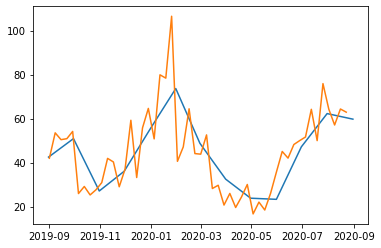

In [631]:
# train.corr()['errors'].sort_values(ascending = False,key = abs)
a.index = a.date
plt.plot(a['pm2_5'].resample('M').mean())
plt.plot(a['pm2_5'].resample('W').mean())

In [599]:
X = train.drop(drop_cols,axis = 1).copy()
test_data  = test.drop(drop_cols,axis = 1).copy()
features_importance= pd.DataFrame({'Feature':[], 'Importance':[]})
models =[]
train_X = X.copy()
train_Y = y.copy()
test_X = test_data.copy()
print(f"Shape of train_X : {train_X.shape}, test_X: {test_X.shape}, train_Y: {train_Y.shape}")

predictors = list(train_X.columns)
# print(f"List of features to be used {list(predictors)}")

# Selecting n_splits to be 3, since class 42 has 
# just 3 instances
# kf = KFold(random_state=seed_lgb,n_splits=K_FOLDS, shuffle=shuffle_lgb)
y_oof_lgb = np.zeros(shape=(len(train_X),))
y_predicted_lgb = np.zeros(shape=(len(test_X),))
cv_scores = []
fold = 0
# n_folds = K_FOLDS
# for train_index, validation_index in kf.split(train_X,train_Y):
train_index =  train.loc[train.date<train.date.max()-timedelta(days = 130)].index.tolist()
validation_index = train.loc[train.date>=train.date.max()-timedelta(days = 130)].index.tolist()
X_train, X_validation, y_train, y_validation = _get_X_Y_DF_from_CV(
        train_X, train_Y, train_index, validation_index
    )

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_validation, y_validation, reference=lgb_train)

model = lgb.train(
        lgb_params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        verbose_eval=100,
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        num_boost_round=N_ESTIMATORS,
        feature_name=predictors,
        categorical_feature="auto",
    )
y_oof_lgb = model.predict(
        X, num_iteration=model.best_iteration
    )

y_predicted_lgb += model.predict(
        test_data.values, num_iteration=model.best_iteration
    )
fold_importance_df= pd.DataFrame({'Feature':[], 'Importance':[]})
fold_importance_df['Feature']= predictors
fold_importance_df['Importance']= model.feature_importance()
fold_importance_df["fold"] = fold + 1
features_importance = pd.concat([features_importance, fold_importance_df], axis=0)
models.append(model)

best_iteration = model.best_iteration
print(f"Best number of iterations for fold {fold} is: {best_iteration}")

cv_oof_score = metrics.mean_absolute_error(y_validation, y_oof_lgb[validation_index])
cv_scores.append(cv_oof_score)
print(f"CV OOF Score for fold {fold} is {cv_oof_score}")

# y_predicted_lgb /= n_folds
oof_score = round(metrics.mean_absolute_error(train_Y, y_oof_lgb), 5)
avg_cv_scores = round(sum(cv_scores) / len(cv_scores), 5)
std_cv_scores = round(np.array(cv_scores).std(), 5)
#     return y_predicted_lgb,models,y_oof_lgb,oof_score,features_importance

Shape of train_X : (9923, 84), test_X: (4254, 84), train_Y: (9923,)
Training until validation scores don't improve for 30 rounds
[100]	training's l1: 15.0894	valid_1's l1: 16.0851
[200]	training's l1: 12.0212	valid_1's l1: 14.9079
Early stopping, best iteration is:
[220]	training's l1: 11.6211	valid_1's l1: 14.9039
Best number of iterations for fold 0 is: 220
CV OOF Score for fold 0 is 14.903934846628784


Feature        object
Importance    float64
dtype: object


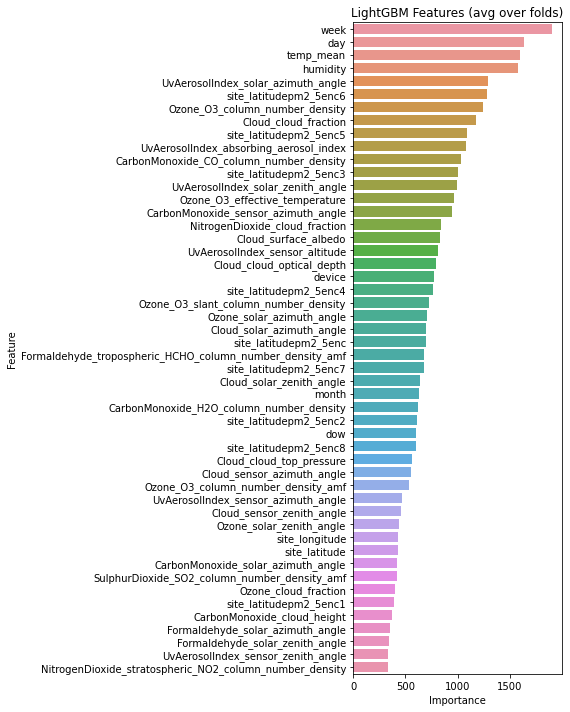

In [600]:
display_importances(features_importance_lgb)
# pvp = train.sort_values(by = 'date').pivot(index = 'site_latitude', columns = 'date',values = 'pm2_5')

In [369]:
# pvp.shape
# pvp.iloc[0]
# for i in range(pvp.shape[0]):
# i = 1
# plt.plot(train.loc[train.site_latitude == train.site_latitude.unique()[i] ].groupby('site_latitude')['pm2_5'].expanding().mean().reset_index(0)['pm2_5'].values)

In [484]:
# train['date']

In [362]:
# train.loc[train.site_latitude == train.site_latitude.unique()[i],['date','pm2_5']]
# train.loc[train.date<train.date.min()+ timedelta(days = 200)]
def cust_split(X,y,n_splits):
    tr = []
#     val = []
    sizes = X['date'].max() - X['date'].min() 
    for i in range(n_splits):
        tr.append((X.loc[X.date< (((i+1)/n_splits)*sizes + X['date'].min())].index.tolist(),X.loc[X.date>= (((i+1)/n_splits)*sizes + X['date'].min())].index.tolist()))
    return tr
# train.site_latitude.unique().shape[0]

In [363]:
# tr= cust_split(train,y,5)

In [485]:
# val[3]
# tr

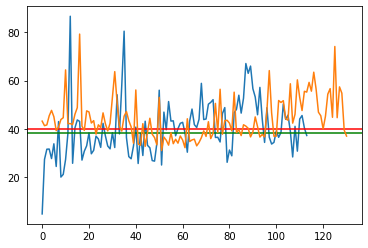

In [513]:
# plt.pl
# train.groupby('site_latitude').size().sort_values()
plt.plot(train.loc[train.site_latitude == 0.35799].sort_values(by = 'date')['pm2_5'].values)
plt.axhline(y = train.loc[train.site_latitude == 0.35799].sort_values(by = 'date')['pm2_5'].mean(),color = 'red')
plt.axhline(y = train.loc[train.site_latitude == 0.35799].sort_values(by = 'date')['pm2_5'].median(),color = 'green')
plt.plot(test.loc[test.site_latitude == 0.35799].sort_values(by = 'date')['pm2_5'].values)

In [213]:
# train.resample('M')
# train.index = train.date
# X = [[0], [1], [2], [3]]
# y = [0, 0, 1, 1]
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(train.drop(drop_cols,axis = 1).fillna(-1000), y)

neigh_preds = neigh.predict(test.drop(drop_cols,axis = 1).fillna(-1000))
# means

In [195]:
means = train.groupby('site_latitude').apply(lambda x : x['pm2_5'].resample('Y').mean()).reset_index()

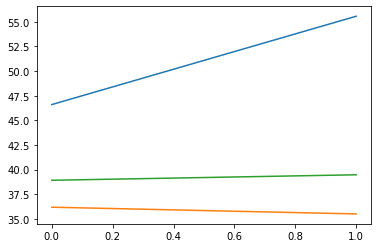

In [197]:
plt.plot(means.loc[means.site_latitude == means.site_latitude.unique()[3],'pm2_5' ].values)
plt.plot(means.loc[means.site_latitude == means.site_latitude.unique()[1],'pm2_5' ].values)
plt.plot(means.loc[means.site_latitude == means.site_latitude.unique()[2],'pm2_5' ].values)
# 

In [593]:
def anal(i,preds,y_oof,log = False):
    if log:
        test['pm2_5'] = np.exp(preds)
    else:
        test['pm2_5'] = preds

    all_data = pd.concat([train,test])
    a = all_data.groupby('site_latitude').get_group(all_data.site_latitude.unique()[i])[['date','pm2_5','Train']]
    y1 = a.loc[a.Train == 1].sort_values(by = 'date')['pm2_5'].values
    y2 = a.loc[a.Train == 0].sort_values(by = 'date')['pm2_5'].values
    x1 = range(len(y1))
    x2 = range(len(y1),len(y1)+len(y2))
    if log :
        y3 = np.exp(y_oof[a.loc[a.Train == 1].index])
    else:
        y3 = y_oof[a.loc[a.Train == 1].index]
    plt.plot(x1,y1,label = 'true')
    plt.plot(x1,y3)
    plt.plot(x2,y2)
    

In [594]:
# train_ori.describe()

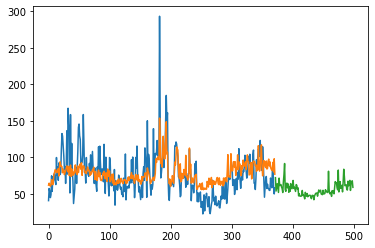

In [601]:
# anal(4,y_predicted_lgb,y_oof_lgb)
anal(2,y_predicted_lgb,y_oof_lgb)
# sns.distplot(test['pm2_5'])
# plt.plot(np.log(train.pm2_5.sort_values(ascending = False)).values)
# np.exp(5)
# sns.distplot(np.log(train.pm2_5),fit = norm)
# sns.distplot(train.groupby('site_latitude')['pm2_5'].diff().dropna())
# test['pm2_5'] = test['site_latitude'].map(train.groupby('site_latitude')['pm2_5'].mean())
# sns.distplot(train['pm2_5'])
# train.groupby('site_latitude')['site_longitude'].unique()

In [602]:
test[['ID','pm2_5']]

,ID,pm2_5
0,ID_OC21YTIKX2,65.724431
1,ID_ZS2RAN8HZT,76.561677
2,ID_X5RLD131U1,67.751355
3,ID_3O2ZUT59OO,69.447611
4,ID_WGF1986WB4,59.923627
...,...,...
4249,ID_FO4YN5QN6I,53.686750
4250,ID_CEVYPKUPGM,53.800929
4251,ID_YWYBKXUSYM,53.263759
4252,ID_Y7HLFD3N76,51.118309


In [603]:
# test[['ID','pm2_5']].to_csv('moyene.csv',index = False)
# test[['pm2_5']].isna().sum()
test[['ID','pm2_5']].to_csv('002_folds_bis.csv',index = False)

In [415]:
# sub = preds_to_sub(test,np.exp(y_predicted_lgb))
# i = 0

# [i for i in test.site_latitude.unique() if i not in train.site_latitude.unique() ]
# abs(train['site_latitude']-0.33261).argmin()
# train.loc[680]
# test.loc[test.site_latitude == 0.33261]
# train.groupby('site_latitude').size()
# i = 3
# (train.loc[train.site_latitude == train.site_latitude.unique()[i]].dropna()['pm2_5'].mean(), 
# train.loc[train.site_latitude == train.site_latitude.unique()[i]]['pm2_5'].mean())


In [422]:
# train.Train

In [568]:

all_data = pd.concat([train, test])
train = all_data.loc[all_data.Train == 1].reset_index(drop = True) 
test = all_data.loc[all_data.Train == 0].reset_index(drop = True)

In [440]:
# sub.loc[sub.ID == 'ID_3E7KH74OPM']
# sub.to_csv('exp.csv',index = False)
# sub
train.drop('shifted_1',axis = 1).groupby('site_code').get_group(8).corr()['pm2_5'].sort_values(ascending = False, key = abs)

pm2_5                                                     1.000000
CarbonMonoxide_CO_column_number_density                   0.677449
NitrogenDioxide_NO2_column_number_density                 0.545556
NitrogenDioxide_tropospheric_NO2_column_number_density    0.506764
humidity                                                 -0.455418
                                                            ...   
device                                                         NaN
site_latitude                                                  NaN
site_longitude                                                 NaN
Train                                                          NaN
site_code                                                      NaN
Name: pm2_5, Length: 86, dtype: float64

<AxesSubplot:xlabel='pm2_5', ylabel='Density'>

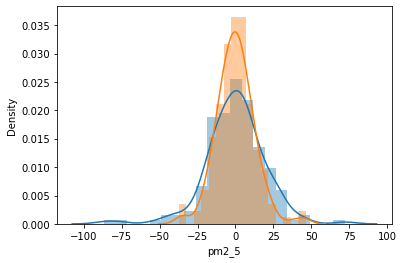

In [476]:

# lim = a.date.min() + (a.date.max() - a.date.min())/2
# a1 = a[a.date<lim]
# a2 = a[a.date>=lim]
# sns.distplot(((a1['pm2_5']).diff().dropna()))
# sns.distplot(((a2['pm2_5']).diff().dropna()))


In [656]:
# a = train.groupby('site_code').get_group(2)
# a.index = a.date
# plt.plot(a['pm2_5'].resample('W').mean())
# a.iloc[232]
# train.loc[train.date == a.iloc[232]['date'] ].describe()['pm2_5']
train['pm2_5'].sort_values(ascending = False)

7424    440.920000
3391    293.105317
3390    277.510000
1579    266.071800
5225    247.904367
           ...    
6439      4.055550
6113      3.681824
3859      1.798678
6209      1.348777
7073      1.160400
Name: pm2_5, Length: 9923, dtype: float64

1
87.22123988095238
0
133.3394286484594
20
128.94185634920635
7
143.95665119047618
22
113.07569642857145
4
106.49472181677018
11
97.85995357142858
8
93.30252440476191
25
94.86477391304348
21
155.94473324808186
29
126.10053162013355
14
179.42421363636365
2
440.92
26
136.30302976190475
24
93.89376923076922
13
86.4045
3
83.33044513457557
31
92.84578674948241
15
92.07378623188404
9
85.45515527950313
18
105.51810300207039
23
114.14940217391305
16
86.06447722567289
19
98.56124223602485
33
95.1801708074534
12
93.57944444444445
5
93.81192028985507
32
115.07087789115647
34
100.32092995580808
30
109.85841045918366
6
120.63593154761905
10
74.15428463564214
28
81.19387300724637
27
56.75566571428572


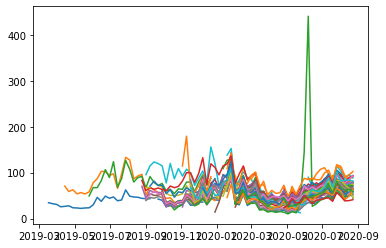

In [646]:
# a = train.groupby('site_code').get_group(1)
# a.index = a.date
# plt.plot(a['pm2_5'].resample('M').mean())
for i in train.site_code.unique():
    
    b = train.groupby('site_code').get_group(i)
    b.index = b.date
    print(i)
    print(b['pm2_5'].resample('W').mean().max())
    plt.plot(b['pm2_5'].resample('W').mean())

Timestamp('2019-12-01 00:00:00')

<AxesSubplot:xlabel='pm2_5', ylabel='Density'>

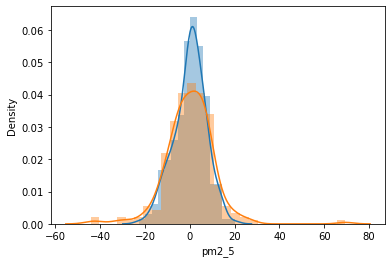

In [159]:
(y_predicted_lgb+test['mean'].values).shape

(4254,)

In [160]:
test.shape

(4254, 89)

In [48]:
sub

In [49]:
sub.to_csv('lgb_5.csv',index = False)

In [60]:
from catboost import Pool, CatBoostRegressor
params_cat = {'iterations':1500,
        'learning_rate':0.01,
        'random_strength':0.1,
        'depth':8,
        'loss_function':'MAE',
        'eval_metric':'MAE',
        'verbose' : 100}
y_predicted_cat,models_cat,y_oof_cat,oof_score_cat =train_catbo(train.drop(drop_cols,axis = 1),
                                                                y,test.drop(drop_cols,axis = 1),params_cat,42,
                                                               True)